### Imports

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. Augmentation 데이터셋 준비

### 1-1) CutMix

### 1-2) 데이터셋 불러오기

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


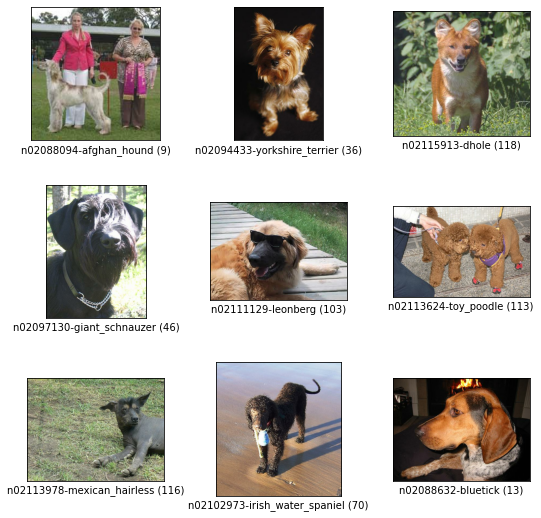

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### 1-3) 이미지 섞기

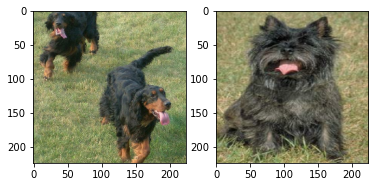

In [8]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [9]:
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

In [10]:
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(102, shape=(), dtype=int32) tf.Tensor(36, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


In [12]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

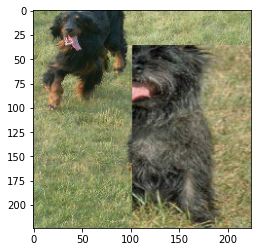

In [13]:
mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

### 1-4) 라벨 섞기

In [14]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [15]:
mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.542889  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

### 1-5) cutmix() 함수 구현

In [16]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 1-6) 수정된 apply_normalize_on_dataset()

In [17]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_crop(image, [224, 224, 3])
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image,label

def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
#     label = tf.reshape(tf.stack(label),(batch_size, num_classes))
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [18]:
num_classes = ds_info.features["label"].num_classes

In [19]:
apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=False, with_cutmix=True)

<PrefetchDataset shapes: ((16, 224, 224, 3), (16, 120)), types: (tf.float32, tf.float32)>

### 2. 모델 생성 및 훈련

### 2-1) 데이터 준비

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.005
batch_size = 16

es_3 = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
es_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
es = es_5

steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size)
validation_steps=int(ds_info.splits['test'].num_examples/batch_size)
epochs=20


In [21]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=False,
)
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=False,
)
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=False,
    with_cutmix=True,
)
ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=batch_size,
    with_aug=True,
    with_cutmix=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 2-2) 모델

In [23]:
tf.random.set_seed(1994)

#### ResNet50, Normal Data

In [24]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_normal = resnet50.fit(
    ds_train_normal, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 110s 146ms/step - loss: 2.7375 - accuracy: 0.3657 - val_loss: 3.3961 - val_accuracy: 0.2056
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 1.0434 - accuracy: 0.7229 - val_loss: 1.2107 - val_accuracy: 0.6495
Epoch 3/20
750/750 [==============================] - 113s 151ms/step - loss: 0.5203 - accuracy: 0.8805 - val_loss: 0.9722 - val_accuracy: 0.7099
Epoch 4/20
750/750 [==============================] - 113s 151ms/step - loss: 0.2526 - accuracy: 0.9572 - val_loss: 0.9584 - val_accuracy: 0.7214
Epoch 5/20
750/750 [==============================] - 114s 153ms/step - loss: 0.1488 - accuracy: 0.9828 - val_loss: 0.9687 - val_accuracy: 0.7215
Epoch 6/20
750/750 [==============================] - 116s 154ms/step - loss: 0.0922 - accuracy: 0.9931 - val_loss: 0.9446 - val_accuracy: 0.7261
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0490 - accuracy: 0.9983 - val_loss: 0.9598 -

In [26]:
del resnet50

#### ResNet50, Augmented data

In [27]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [29]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
   ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 111s 148ms/step - loss: 2.9573 - accuracy: 0.3133 - val_loss: 2.1427 - val_accuracy: 0.4334
Epoch 2/20
750/750 [==============================] - 112s 149ms/step - loss: 1.3667 - accuracy: 0.6234 - val_loss: 1.5364 - val_accuracy: 0.5679
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 0.9420 - accuracy: 0.7363 - val_loss: 1.4714 - val_accuracy: 0.5823
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 0.6443 - accuracy: 0.8223 - val_loss: 1.1788 - val_accuracy: 0.6567
Epoch 5/20
750/750 [==============================] - 115s 153ms/step - loss: 0.4675 - accuracy: 0.8778 - val_loss: 1.2496 - val_accuracy: 0.6431
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 0.3084 - accuracy: 0.9287 - val_loss: 1.2304 - val_accuracy: 0.6569
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 0.2466 - accuracy: 0.9435 - val_loss: 1.2414 -

In [30]:
del aug_resnet50

####  ResNet50, CutMix data

In [31]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [32]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 114s 152ms/step - loss: 4.1250 - accuracy: 0.1620 - val_loss: 3.4815 - val_accuracy: 0.1947
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 3.1467 - accuracy: 0.3838 - val_loss: 1.4317 - val_accuracy: 0.6055
Epoch 3/20
750/750 [==============================] - 115s 153ms/step - loss: 2.8216 - accuracy: 0.4776 - val_loss: 1.1844 - val_accuracy: 0.6672
Epoch 4/20
750/750 [==============================] - 115s 153ms/step - loss: 2.6023 - accuracy: 0.5476 - val_loss: 1.1811 - val_accuracy: 0.6722
Epoch 5/20
750/750 [==============================] - 116s 155ms/step - loss: 2.4829 - accuracy: 0.5828 - val_loss: 1.0462 - val_accuracy: 0.7111
Epoch 6/20
750/750 [==============================] - 116s 155ms/step - loss: 2.3421 - accuracy: 0.6261 - val_loss: 1.0682 - val_accuracy: 0.7014
Epoch 7/20
750/750 [==============================] - 117s 156ms/step - loss: 2.2748 - accuracy: 0.6546 - val_loss: 1.0827 -

In [33]:
del cutmix_resnet50

#### ResNet50, Augmented + CutMix data

In [34]:
all_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [36]:
all_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=lr),
    metrics=['accuracy'],
)

history_resnet50_all = all_resnet50.fit(
    ds_train_all, # augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es]
)

Epoch 1/20
750/750 [==============================] - 114s 152ms/step - loss: 4.3598 - accuracy: 0.1002 - val_loss: 2.7453 - val_accuracy: 0.3024
Epoch 2/20
750/750 [==============================] - 114s 151ms/step - loss: 3.4003 - accuracy: 0.3084 - val_loss: 1.8097 - val_accuracy: 0.5118
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 3.0516 - accuracy: 0.4062 - val_loss: 1.4067 - val_accuracy: 0.6090
Epoch 4/20
750/750 [==============================] - 115s 153ms/step - loss: 2.8911 - accuracy: 0.4560 - val_loss: 1.5172 - val_accuracy: 0.5718
Epoch 5/20
750/750 [==============================] - 116s 154ms/step - loss: 2.7433 - accuracy: 0.5017 - val_loss: 1.3242 - val_accuracy: 0.6441
Epoch 6/20
750/750 [==============================] - 117s 156ms/step - loss: 2.6456 - accuracy: 0.5257 - val_loss: 1.3116 - val_accuracy: 0.6319
Epoch 7/20
750/750 [==============================] - 117s 156ms/step - loss: 2.5492 - accuracy: 0.5583 - val_loss: 1.4080 -

In [37]:
del all_resnet50

### 2-3) 결과 비교

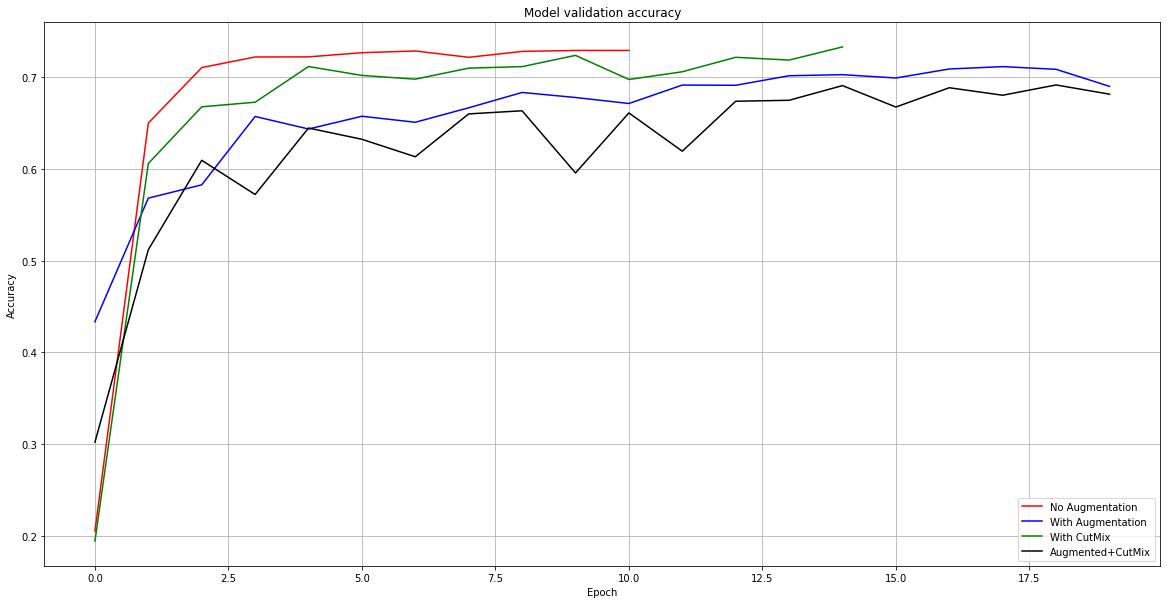

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(history_resnet50_normal.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_all.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_Accuracy.png')
plt.show()

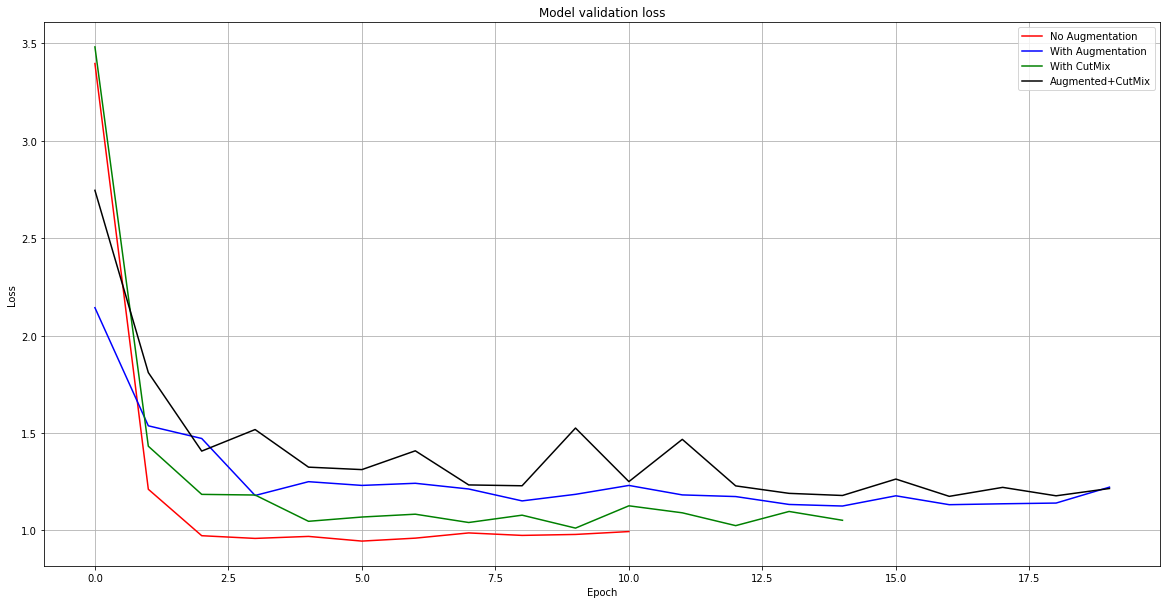

In [39]:
plt.figure(figsize=(20,10))
plt.plot(history_resnet50_normal.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_all.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'Augmented+CutMix'], loc='best')
plt.grid(True)
plt.savefig('fig1_loss.png')
plt.show()

In [40]:
print(f"Augmentation X, CutMix X Data's best accuracy : {round(max(history_resnet50_normal.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix X Data's best accuracy : {round(max(history_resnet50_aug.history['val_accuracy']), 3)}")
print(f"Augmentation X, CutMix O Data's best accuracy : {round(max(history_resnet50_cutmix.history['val_accuracy']), 3)}")
print(f"Augmentation O, CutMix O Data's best accuracy : {round(max(history_resnet50_all.history['val_accuracy']), 3)}")

Augmentation X, CutMix X Data's best accuracy : 0.729
Augmentation O, CutMix X Data's best accuracy : 0.711
Augmentation X, CutMix O Data's best accuracy : 0.732
Augmentation O, CutMix O Data's best accuracy : 0.691


### 느낀점(회고)

Augmentation을 수행하지 않았을 경우, CutMix한 데이터가 일반 데이터에 비해서 정확도가 높게 나왔다.
그러나, 일반 데이터나 CutMix한 데이터나 Augmentation을 수행했을 때, 정확도는 내려갔고, 일반 데이터가 더 높게 나왔다.